# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [118]:
import numpy as np
from scipy import optimize
import sympy as sm
from scipy.optimize import minimize 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
#import modelproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

**Write out the model in equations here.** 

Make sure you explain well the purpose of the model and comment so that other students who may not have seen it before can follow.  

In this project we cosider a version of the Malthus Model.<br> Households gets utility from consumption (c) and number of surviving children (n) <br>
$u(c_t,n_t) = \ln(c_t) + \beta\ln(n_t)$ <br>
The budget constraints are: <br>
$I_t = c_t + \lambda n_t + pb_t$ <br>
where I is income and p is a cost that falls on the household whether the child survives or not<br> The variable b captures the number of births.
<br>A fraction of these, $\sigma$, lead to the born children surviving until they become adults.<br>
$n_t = \sigma b_t; 0 < \sigma < 1$ <br>
Income per capita in period t is given by:<br>
$I_t=A(\frac{X}{L_t})^{1-\alpha}$, where A is technology, X is land and L is population. <br>
Population in the next period is the number of births and the people surving this period: <br>
$L_{t+1}=n_tL_t+(1-\mu)L_t$, where $\mu$ is adult mortality.   


Plot of utility function 

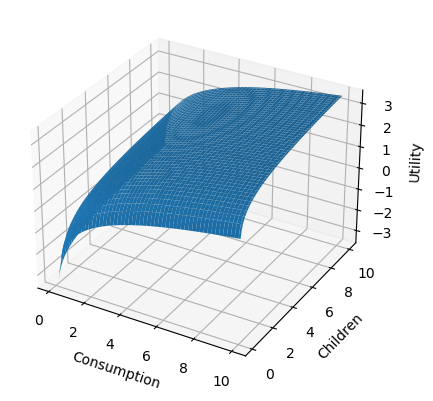

In [119]:


# Define the range of values for consumption and leisure
c_range = np.linspace(0.1, 10, 100)
n_range = np.linspace(0.1, 10, 100)

# Create a meshgrid of the range of values
c, n = np.meshgrid(c_range, n_range)

# Define the utility function
beta = 0.5
u = np.log(c) + beta * np.log(n)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(c, n, u)
ax.set_xlabel('Consumption')
ax.set_ylabel('Children')
ax.set_zlabel('Utility')
plt.show()

1) Solving the utility maximizing problem 

In [120]:
# Define utility function
def utility(x,beta):
    c, n = x
    return np.log(c) + beta*np.log(n)

# Define budget constraint
def budget_constraint(x,I,Lambda,p,sigma):
    c, n = x
    return I - c - Lambda*n - p*n/sigma  # violated if negative

# Define function to maximize utility subject to budget constraint
def maximize_utility(I,Lambda,p,sigma,beta):
    x0 = np.array([I/2, I/2])  # initial guess for c and n
    bounds = ((0, I), (0, I))  # bounds for c and n
    def constraint_func(x, I, Lambda, p, sigma):
        c, n = x
        b = n/sigma
        return np.array([
            I - c - Lambda*n - p*b,
            n - sigma*b
        ])
    constraints = ({'type': 'ineq', 'fun': constraint_func, 'args': (I, Lambda, p, sigma)})
    res = minimize(lambda x: -utility(x, beta), x0, method='SLSQP', bounds=bounds, constraints=constraints)
    return res

# Values of parameters 
I = 200  # income
Lambda = 0.5  # price of surviving children
p = 2  # cost that falls on the household whether the child survives or not
sigma = 0.8  # survival rate
beta = 0.5  # preference parameter
res = maximize_utility(I, Lambda, p, sigma, beta)


Print results

In [121]:
optimal_c = res.x[0] 
optimal_n = res.x[1]
optimal_b = res.x[1]/sigma
print(f"Optimal consumption: {optimal_c:.2f}")
print(f"Optimal number of surviving children: {optimal_n:.2f}")
print(f"Optimal number of births: {optimal_b:.2f}")

Optimal consumption: 133.33
Optimal number of surviving children: 22.22
Optimal number of births: 27.78


Check that solution match analytical solution 

In [122]:
n = I * beta * sigma / (beta * Lambda * sigma + beta * p + Lambda* sigma + p)
b=n/sigma
print(n)
print(b)

22.22222222222222
27.777777777777775


2) How does population evovle given optimal number of surviving chilrden?

In [125]:
# Define utility function
def utility(x, beta):
    c, n = x
    return np.log(c) + beta*np.log(n)

# Define budget constraint
def budget_constraint(x, I, Lambda, p, sigma):
    c, n = x
    return I - c - Lambda*n - p*n/sigma  # violated if negative

# Define income per capita 
def income(X, L, A, alpha):
    return A*(X/L)**(1-alpha)

# Define function to maximize utility subject to budget constraint
def maximize_utility(X, L, A, alpha, Lambda, p, sigma, beta):
    I = income(X, L, A, alpha)
    x0 = np.array([I/2, 1])  # initial guess for c and n
    bounds = ((0, I), (0, None))  # bounds for c and n
    def constraint_func(x, I, Lambda, p, sigma):
        c, n = x
        b = n/sigma
        return np.array([
            I - c - Lambda*n - p*b,
        ])
    constraints = ({'type': 'ineq', 'fun': constraint_func, 'args': (I, Lambda, p, sigma)})
    res = minimize(lambda x: -utility(x, beta), x0, method='SLSQP', bounds=bounds, constraints=constraints)
    return res

# Define population in next period 
def next_period_population(L, n_optimal, mu):
    return n_optimal * L + (1 - mu) * L

# Set parameter values
X = 10  # land
L = 1000  # initial population
A = 1  # productivity parameter
alpha = 0.5  # parameter in production function
Lambda = 1  # price of surviving children
p = 1  # cost that falls on the household whether the child survives or not
sigma = 0.8  # survival rate
beta = 0.5  # preference parameter
mu = 0.01  # mortality rate

# Iterate to find steady state population
tolerance = 1e-8
max_iter = 1000
n_optimal = 1
for i in range(max_iter):
    res = maximize_utility(X, L, A, alpha, Lambda, p, sigma, beta)
    n_optimal_new = res.x[1]
    L_new = next_period_population(L, n_optimal_new, mu)
    if abs(L_new - L) < tolerance:
        break
    n_optimal = n_optimal_new
    L = L_new
    I = income(X, L, A, alpha)

# Print results
print(f"Steady state population size: {L}")
print(f"Optimal number of children: {n_optimal}")
print(f"Steady state income: {I}")

C:\Users\johan\AppData\Local\Temp\ipykernel_17428\66086324.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(c) + beta*np.log(n)


Steady state population size: 2186.6610208888274
Optimal number of children: 0.01002270967739357
Steady state income: 0.06762530990136591


Tjek that solution match analytical solution 

In [127]:
analytical_SS_income = ((1+beta)*(Lambda+p/sigma)*mu)/beta
analytical_SS_income

0.0675

Plot of population and income 

C:\Users\johan\AppData\Local\Temp\ipykernel_17428\66086324.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(c) + beta*np.log(n)


Steady state population size: 2186.6610208888274
Optimal number of children: 0.01002270967739357
Steady state income: 0.06762530990136591


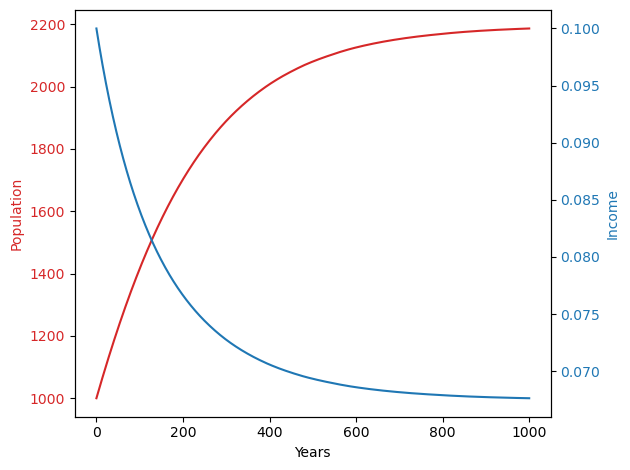

In [126]:
import matplotlib.pyplot as plt

# Set parameter values
X = 10  # land
L = 1000  # initial population
A = 1  # productivity parameter
alpha = 0.5  # parameter in production function
Lambda = 1  # price of surviving children
p = 1  # cost that falls on the household whether the child survives or not
sigma = 0.8  # survival rate
beta = 0.5  # preference parameter
mu = 0.01  # mortality rate

# Iterate to find steady state population
tolerance = 1e-8
max_iter = 1000
n_optimal = 1
population = [L]
income_list = [income(X, L, A, alpha)]
for i in range(max_iter):
    res = maximize_utility(X, L, A, alpha, Lambda, p, sigma, beta)
    n_optimal_new = res.x[1]
    L_new = next_period_population(L, n_optimal_new, mu)
    if abs(L_new - L) < tolerance:
        break
    n_optimal = n_optimal_new
    L = L_new
    population.append(L_new)
    income_list.append(income(X, L_new, A, alpha))

# Print results
print(f"Steady state population size: {L}")
print(f"Optimal number of children: {n_optimal}")
print(f"Steady state income: {income(X, L, A, alpha)}")

# Create plot
fig, ax1 = plt.subplots()

# Plot population
color = 'tab:red'
ax1.set_xlabel('Years')
ax1.set_ylabel('Population', color=color)
ax1.plot(population, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Add income plot
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Income', color=color)
ax2.plot(income_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

Analytical solution in sympy

In [ ]:
A = sm.symbols('A')
X = sm.symbols('X')
Alpha = sm.symbols('alpha')
c = sm.symbols('c')
n = sm.symbols('n_t')
I = sm.symbols('I')
Y = sm.symbols('Y')
L = sm.symbols('L_t')
beta = sm.symbols('beta')
Lambda = sm.symbols('lambda')
p = sm.symbols('p')
b = sm.symbols('b')
sigma = sm.symbols('sigma')
mu = sm.symbols('mu')

In [ ]:
objective = sm.ln(c)+ beta * sm.ln(n)
objective

In [ ]:
budget_constraint = sm.Eq(c+Lambda * n + p * b,I)
budget_constraint

In [ ]:
size = sm.Eq(sigma * b,n)
size

In [ ]:
c_from_con = sm.solve(budget_constraint, c)
c_from_con[0]

In [ ]:
b_size = sm.solve(size, b)
b_size[0]

In [ ]:
objective_subs = objective.subs(c, c_from_con[0])
objective_subs

In [ ]:
objective_subs_1 = objective_subs.subs(b, b_size[0])
objective_subs_1

In [ ]:
foc = sm.diff(objective_subs_1, n)
foc

In [ ]:
sol = sm.solve(sm.Eq(foc,0), n)
sol[0]

In [ ]:
Income = sm.Eq(A*(X/L)**(1-Alpha),I)
Income

In [ ]:
Population = sm.Eq(n*L+(1-mu)*L,L)
Population

In [ ]:
Population_1 = Population.subs(n, sol[0])
Population_1

In [ ]:
Population_2 = Population_1.subs(I, Income.lhs)
Population_2

In [ ]:
sol_1 = sm.solve(sm.Eq(Population_2.lhs,0), L)
sol_1[0]

In [ ]:
Income_1 = Income.subs(L, sol_1[0])
Income_1

In [ ]:
beta = 0.5 
lamda = 0.3 
p =  0.3 
sigma = 0.2 
A = 1
X =1 
mu = 0.3 
alpha = 0.3 
obj = lambda Lss: Lss - beta/((1+beta)*(lamda+p/sigma))*A*X**(1-alpha)*Lss**alpha+(1-mu)*Lss
result = optimize.root_scalar(obj,bracket=[0.1,100],method='brentq')

print('the steady state for L is',result.root)

In [ ]:
beta = 0.2
lambda = 0.02
p = 0.01
alpha = 1/3
sigma = 0.1
my =0.5

# write your code here

f = lambda L: L**alpha
obj_Lss = lambda Lss: Lss - (A*X**(1-alpha)*(Lss) + (1-my)*Lss)/((1+beta)*(lambda+(p/sigma)))
result = optimize.root_scalar(obj_Lss,bracket=[0.1,100],method='brentq')

print('the steady state for L is',result.root)

## Analytical solution

If your model allows for an analytical solution, you should provide here.

You may use Sympy for this. Then you can characterize the solution as a function of a parameter of the model.

To characterize the solution, first derive a steady state equation as a function of a parameter using Sympy.solve and then turn it into a python function by Sympy.lambdify. See the lecture notes for details. 

## Numerical solution

You can always solve a model numerically. 

Define first the set of parameters you need. 

Then choose one of the optimization algorithms that we have gone through in the lectures based on what you think is most fitting for your model.

Are there any problems with convergence? Does the model converge for all starting values? Make a lot of testing to figure these things out. 

# Further analysis

Make detailed vizualizations of how your model changes with parameter values. 

Try to make an extension of the model. 

# Conclusion

Add concise conclusion. 